In [584]:
import yfinance as yf
import pandas as pd
import numpy as np
import hvplot.pandas
import holoviews as hv
import matplotlib.pyplot as plt
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import mplfinance as mpf
import ta
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import classification_report
from pathlib import Path
from sklearn.model_selection import train_test_split

In [585]:
#Define a function to create and get the Bollinger Bands
def bollinger_bands(data,window_size = 30):
    rolling_mean = data['Close'].rolling(window=window_size).mean() #Simple Moving Average (SMA)
    rolling_std = data['Close'].rolling(window=window_size).std() #Standard Deviation
    data['UpperBand'] = rolling_mean + (rolling_std * 2) #Upper Bollinger Band
    data['LowerBand'] = rolling_mean - (rolling_std * 2) #Lower Bollinger Band
    return data

In [586]:
# Define a function to compute the Relative Strength Index (RSI)
def RSI(data, window = 13):
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    RS = avg_gain / avg_loss
    RSI = 100 - (100 / (1.0 + RS))
    data['RSI'] = RSI
    data['Overbought'] = 70
    data['Oversold'] = 30
    return data
    



In [587]:
# Define a function to create and get the trading strategy
# Buy whem the close price goes below the lower band and the RSI is below 30 and I have no position
# Sell when the close price goes above the upper band and the RSI is above 70 and I have a position

def strategy(data):
    position = 0
    buy_price = []
    sell_price = []
    for i in range(len(data)):
        if data['Close'][i] < data['LowerBand'][i] and data['RSI'][i] < data['Oversold'][i] and position == 0:
            position = 1
            buy_price.append(data['Close'][i])
            sell_price.append(np.nan)
        elif data['Close'][i] > data['UpperBand'][i] and data['RSI'][i] > data['Overbought'][i] and position == 1:
            position = 0
            buy_price.append(np.nan)
            sell_price.append(data['Close'][i])
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
    return (buy_price, sell_price)



In [588]:
# Get the ETH data
data = yf.download('ETH-USD', start='2023-01-10', end='2024-01-18')
# Set the date as index
data.set_index(pd.DatetimeIndex(data.index.values), inplace=True)
# Show the data
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
2023-01-10,1321.395508,1342.757202,1318.527222,1336.586060,1336.586060,5830173253
2023-01-11,1336.486816,1387.932739,1323.583130,1387.932739,1387.932739,6314904311
2023-01-12,1405.351440,1432.281250,1378.422119,1417.938477,1417.938477,12230193038
2023-01-13,1417.946167,1461.672729,1404.023926,1451.614868,1451.614868,7684148212
2023-01-14,1451.428467,1563.739136,1450.988403,1550.706909,1550.706909,15444626014


In [589]:
# Add the Bollinger Bands to the data
data = bollinger_bands(data)

In [590]:
# Add the RSI to the data
data = RSI(data)


In [591]:
# Adding a moving average as an additional feature
data['Moving_Average'] = data['Close'].rolling(window=5).mean()

In [592]:
# Implement the strategy to the data
buy_price, sell_price = strategy(data)
data['Buy'] = buy_price
data['Sell'] = sell_price


/var/folders/cp/yd9whbw50ng6k5r1tb2hs4t00000gq/T/ipykernel_39455/1406515789.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data['Close'][i] < data['LowerBand'][i] and data['RSI'][i] < data['Oversold'][i] and position == 0:
/var/folders/cp/yd9whbw50ng6k5r1tb2hs4t00000gq/T/ipykernel_39455/1406515789.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif data['Close'][i] > data['UpperBand'][i] and data['RSI'][i] > data['Overbought'][i] and position == 1:
/var/folders/cp/yd9whbw50ng6k5r1tb2hs4t00000gq/T/ipykernel_39455/1406515789.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecate

In [593]:

# Plot the close price, Bollinger bands
plot = data['Close'].hvplot(line_color='blue', label='Close Price', alpha=0.5) * \
       data['UpperBand'].hvplot(line_color='green', label='Upper Band', alpha=0.5) * \
       data['LowerBand'].hvplot(line_color='red', label='Lower Band', alpha=0.5)

# Fill between UpperBand and LowerBand
plot *= data.hvplot.area(x='index', y='LowerBand', y2='UpperBand', alpha=0.3, color='grey')

# Plot Buy and Sell signals
plot *= data.hvplot.scatter(x='index', y='Buy', label='Buy Signal', color='green', marker='^', size=100) * \
        data.hvplot.scatter(x='index', y='Sell', label='Sell Signal', color='red', marker='v', size=100)

# Set options (title, labels)
plot.opts(
    title="Bollinger Bands and RSI Trading Strategy",
    xlabel='Date', ylabel='Close Price USD ($)',
    show_legend=True, width=800, height=400
)

# Display the plot
plot


/Users/DinoK1/anaconda3/envs/dev/lib/python3.10/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/Users/DinoK1/anaconda3/envs/dev/lib/python3.10/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Overlay
   .Curve.Close_Price   :Curve   [index]   (Close)
   .Curve.Upper_Band    :Curve   [index]   (UpperBand)
   .Curve.Lower_Band    :Curve   [index]   (LowerBand)
   .Area.I              :Area   [index]   (LowerBand,UpperBand)
   .Scatter.Buy_Signal  :Scatter   [index]   (Buy)
   .Scatter.Sell_Signal :Scatter   [index]   (Sell)

In [594]:
initial_investment = 100000
cash = initial_investment
shares_held = 0
portfolio_values = []
dates = []

# Loop through the data
for date, row in data.iterrows():
    if row['Buy'] and cash > 0:
        # Buy as many shares as possible with available cash
        shares_held = cash / row['Close']
        cash = 0
    elif row['Sell'] and shares_held > 0:
        # Sell all shares held
        cash = shares_held * row['Close']
        shares_held = 0
    # Calculate the current value of the portfolio
    current_value = cash + shares_held * row['Close']
    portfolio_values.append(current_value)
    dates.append(date)

# The final portfolio value and profit or loss
final_value = portfolio_values[-1]
profit_or_loss = final_value - initial_investment

# Create a DataFrame for the portfolio values
portfolio_eth_df = pd.DataFrame({'Date': dates, 'Portfolio Value': portfolio_values})
portfolio_eth_df = portfolio_eth_df.set_index('Date')

# Plotting the portfolio value
portfolio_plot = portfolio_eth_df['Portfolio Value'].hvplot(
    line_color='green', ylabel='Portfolio Value in USD'
)

# Adding a label for the final portfolio value
final_date = dates[-1]
label = hv.Labels({'x': [final_date], 'y': [final_value], 'text': [f"${final_value:,.2f}"]}, ['x', 'y'], 'text')

# Combine the plots
plot = portfolio_plot * label
plot = plot.opts(
    title='Portfolio Value Over Time', 
    xlabel='Date', 
    width=800, height=400,
    tools=['hover'],
     yformatter='%.0f'
)

# Calculating Daily Returns
portfolio_eth_df['Daily Returns'] = portfolio_eth_df['Portfolio Value'].pct_change()

# Calculating Maximum Drawdown
rolling_max = portfolio_eth_df['Portfolio Value'].cummax()
daily_drawdown = portfolio_eth_df['Portfolio Value'] / rolling_max - 1.0
max_drawdown = daily_drawdown.cummin().min()

# Calculating Sharpe Ratio (assuming risk-free rate is 1%)
risk_free_rate = 0.01
sharpe_ratio = (portfolio_eth_df['Daily Returns'].mean() - risk_free_rate) / portfolio_eth_df['Daily Returns'].std() * np.sqrt(252)

# Print the results for Max Drawdown and Sharpe Ratio
print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


# Print the results
print(f"Final Portfolio Value: ${final_value:,.2f}")
print(f"Profit/Loss: ${profit_or_loss:,.2f}")

# Display the plot
plot



Maximum Drawdown: -26.99%
Sharpe Ratio: -7.77
Final Portfolio Value: $133,167.07
Profit/Loss: $33,167.07


/Users/DinoK1/anaconda3/envs/dev/lib/python3.10/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/Users/DinoK1/anaconda3/envs/dev/lib/python3.10/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Overlay
   .Curve.Portfolio_Value :Curve   [Date]   (Portfolio Value)
   .Labels.I              :Labels   [x,y]   (text)

# Using BACKTEST with Bollinger Bands

In [595]:
# For demonstration, let's fetch some data
eth_df = yf.download("ETH-USD", start="2023-01-01", end="2024-12-31", interval="1d")

[*********************100%%**********************]  1 of 1 completed


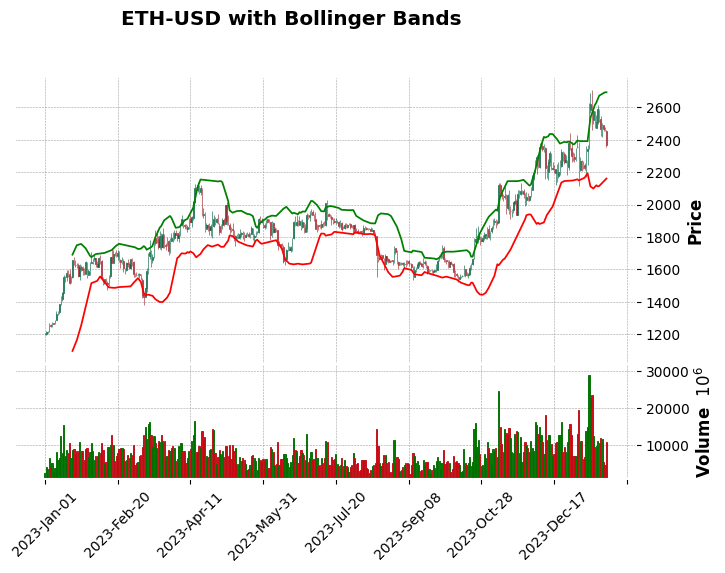

In [596]:
# Calculate Bollinger Bands
window = 20
std_multiplier = 2
eth_df['SMA'] = eth_df['Close'].rolling(window=window).mean()
eth_df['Upper'] = eth_df['SMA'] + (eth_df['Close'].rolling(window=window).std() * std_multiplier)
eth_df['Lower'] = eth_df['SMA'] - (eth_df['Close'].rolling(window=window).std() * std_multiplier)

# Creating separate addplot calls for upper and lower bands
apd_upper = mpf.make_addplot(eth_df['Upper'], color='green')
apd_lower = mpf.make_addplot(eth_df['Lower'], color='red')

# Plotting candlestick chart
mpf.plot(eth_df, type='candle', style='charles', addplot=[apd_upper, apd_lower], volume=True, title="ETH-USD with Bollinger Bands", figratio=(12,8))

In [597]:
# Define the Bollinger Bands Strategy
class BollingerBandsStrategy(Strategy):
    def init(self):
        # Convert the Close prices to a Pandas Series
        close = pd.Series(self.data.Close)

        # Calculate the simple moving average (SMA)
        self.sma = close.rolling(window=20).mean()

        # Calculate the rolling standard deviation
        rolling_std = close.rolling(window=20).std()

        # Define upper and lower bands
        self.upper_band = self.sma + 2 * rolling_std
        self.lower_band = self.sma - 2 * rolling_std

    def next(self):
        # Get the current index
        idx = len(self.data.Close) - 1

        # Buy if the current price is below the lower Bollinger Band
        if self.data.Close[idx] < self.lower_band[idx]:
            self.buy()

        # Sell if the current price is above the upper Bollinger Band
        elif self.data.Close[idx] > self.upper_band[idx]:
            self.sell()

In [598]:
# Backtest the strategy
bt = Backtest(eth_df, BollingerBandsStrategy, cash=100000, commission=0.00, exclusive_orders=True)
outcome = bt.run()


# Plot the backtest result
print(outcome)

Start                     2023-01-01 00:00:00
End                       2024-01-22 00:00:00
Duration                    386 days 00:00:00
Exposure Time [%]                   89.405685
Equity Final [$]                 96023.578735
Equity Peak [$]                 158358.977173
Return [%]                          -3.976421
Buy & Hold Return [%]                97.39943
Return (Ann.) [%]                   -3.754671
Volatility (Ann.) [%]                43.55997
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -42.898309
Avg. Drawdown [%]                   -5.884268
Max. Drawdown Duration      102 days 00:00:00
Avg. Drawdown Duration       16 days 00:00:00
# Trades                                   36
Win Rate [%]                        33.333333
Best Trade [%]                      25.504959
Worst Trade [%]                    -17.589165
Avg. Trade [%]                    

In [599]:
# Plot the backtest result
bt.plot()

/Users/DinoK1/anaconda3/envs/dev/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/DinoK1/anaconda3/envs/dev/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p10966', ...)

# Using Machine Learning as option


In [600]:
# Fetch historical data for Ethereum
ticker = "ETH-USD"
start_date = "2023-01-21"
end_date = "2024-01-22"

# Downloading the data from Yahoo Finance
data = yf.download(ticker, start=start_date, end=end_date)

# Display the first few rows of the data
print(data.head())

[*********************100%%**********************]  1 of 1 completed
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2023-01-21  1659.706055  1674.179321  1626.812988  1627.118164  1627.118164   
2023-01-22  1627.365967  1658.023438  1612.085693  1628.382080  1628.382080   
2023-01-23  1628.550781  1641.218140  1607.903076  1628.251099  1628.251099   
2023-01-24  1627.848267  1639.723877  1551.389771  1556.604248  1556.604248   
2023-01-25  1556.807495  1632.241699  1530.797852  1611.711060  1611.711060   

                 Volume  
Date                     
2023-01-21   8859250310  
2023-01-22   7517988734  
2023-01-23   8264507375  
2023-01-24   8180274691  
2023-01-25  10598973448  


In [601]:
# Define the window size for the moving average and standard deviation
window_size = 20
std_dev_multiplier = 2

# Calculate the middle band (simple moving average)
data['Middle_Band'] = data['Close'].rolling(window=window_size).mean()

# Calculate the standard deviation
data['Std_Dev'] = data['Close'].rolling(window=window_size).std()

# Calculate the upper and lower bands
data['Upper_Band'] = data['Middle_Band'] + (data['Std_Dev'] * std_dev_multiplier)
data['Lower_Band'] = data['Middle_Band'] - (data['Std_Dev'] * std_dev_multiplier)

# Drop any NaN values from the DataFrame
data = data.dropna()
data.head()


,Open,High,Low,Close,Adj Close,Volume,Middle_Band,Std_Dev,Upper_Band,Lower_Band
Date,,,,,,,,,,
2023-02-09,1651.082275,1655.234863,1537.182251,1546.438232,1546.438232,10524969124,1617.983618,37.162267,1692.308152,1543.659084
2023-02-10,1546.596558,1553.325684,1504.834473,1514.869141,1514.869141,8397387897,1612.371167,43.624481,1699.620128,1525.122206
2023-02-11,1514.941895,1541.334717,1510.146973,1539.926758,1539.926758,5064007416,1607.948401,46.316666,1700.581732,1515.315069
2023-02-12,1539.776001,1545.554199,1501.462036,1515.033691,1515.033691,5319698775,1602.287531,50.439892,1703.167315,1501.407746
2023-02-13,1514.916992,1524.731445,1470.023926,1507.165894,1507.165894,9363855114,1599.815613,53.889960,1707.595532,1492.035693


In [602]:
# Initialize the `signal` column to 0
data['Signal'] = 0.0

# Generate buy signals
data.loc[data['Close'] < data['Lower_Band'], 'Signal'] = 1.0

# Generate sell signals
data.loc[data['Close'] > data['Upper_Band'], 'Signal'] = -1.0

/var/folders/cp/yd9whbw50ng6k5r1tb2hs4t00000gq/T/ipykernel_39455/3306739603.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'] = 0.0


In [603]:
# Selecting features to scale (using 'Close', 'Upper_Band', and 'Lower_Band' for example)
features = ['Close', 'Upper_Band', 'Lower_Band']
X = data[features]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the features
X_scaled = scaler.fit_transform(X)


In [604]:
# Calculate the index for splitting the data
split_idx = int(len(X_scaled) * 0.8)

# Split the features data
X_train_scaled = X_scaled[:split_idx]
X_test_scaled = X_scaled[split_idx:]

# Split the target variable ('Signal')
y = data['Signal']
y_train = y[:split_idx]
y_test = y[split_idx:]

In [605]:
# Create the SVM model
svm_model = svm.SVC()

# Fit the model to the scaled training data
svm_model.fit(X_train_scaled, y_train)

SVC()

In [606]:
# Predict the trading signals on the training data
training_predictions = svm_model.predict(X_train_scaled)

# Predict the trading signals on the testing data
testing_predictions = svm_model.predict(X_test_scaled)

# Evaluate the model's performance
print("Model Performance on Training Set:")
print(classification_report(y_train, training_predictions))

print("Model Performance on Testing Set:")
print(classification_report(y_test, testing_predictions))

Model Performance on Training Set:
              precision    recall  f1-score   support

        -1.0       1.00      0.28      0.43        18
         0.0       0.91      1.00      0.95       248
         1.0       0.00      0.00      0.00        11

    accuracy                           0.91       277
   macro avg       0.64      0.43      0.46       277
weighted avg       0.88      0.91      0.88       277

Model Performance on Testing Set:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         7
         0.0       0.90      1.00      0.95        63

    accuracy                           0.90        70
   macro avg       0.45      0.50      0.47        70
weighted avg       0.81      0.90      0.85        70



/Users/DinoK1/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/DinoK1/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/DinoK1/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [607]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for the SVM model
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'kernel': ['rbf', 'linear', 'sigmoid']  # Specifies the kernel type to be used in the algorithm
}

# Create a GridSearchCV object
grid_search = GridSearchCV(svm.SVC(), param_grid, cv=5, scoring='accuracy', verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .................C=0.1, gamma=scale, ke

In [608]:
# Create a new SVM model with the best parameters
tuned_svm_model = svm.SVC(C=grid_search.best_params_['C'],
                          gamma=grid_search.best_params_['gamma'],
                          kernel=grid_search.best_params_['kernel'])

# Fit the model to the scaled training data
tuned_svm_model.fit(X_train_scaled, y_train)

# Predict the trading signals on the training data
training_predictions = tuned_svm_model.predict(X_train_scaled)

# Predict the trading signals on the testing data
testing_predictions = tuned_svm_model.predict(X_test_scaled)

# Evaluate the model's performance
print("Model Performance on Training Set:")
print(classification_report(y_train, training_predictions))

print("Model Performance on Testing Set:")
print(classification_report(y_test, testing_predictions))

Model Performance on Training Set:
              precision    recall  f1-score   support

        -1.0       1.00      0.83      0.91        18
         0.0       0.97      1.00      0.98       248
         1.0       1.00      0.55      0.71        11

    accuracy                           0.97       277
   macro avg       0.99      0.79      0.87       277
weighted avg       0.97      0.97      0.97       277

Model Performance on Testing Set:
              precision    recall  f1-score   support

        -1.0       0.64      1.00      0.78         7
         0.0       1.00      0.94      0.97        63

    accuracy                           0.94        70
   macro avg       0.82      0.97      0.87        70
weighted avg       0.96      0.94      0.95        70

